In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [17]:
# Input data
n_sequence=1
spatial_points = 30
lyap_exp = 0.0461
ks_data, xx, tt = data1D.kuramoto_sivashinsky(sequence_length=1000, n_sequence=n_sequence, spatial_points=spatial_points)

b = Reservoir(n_res=2000, res_scale=1, res_encoding=None, res_enc_param=1.5*np.pi,
              input_scale=1, input_encoding=None,
              random_projection='simulation', weights_type='gaussian',
              activation_fun='intensity', activation_param=1,
              parallel_runs=1,  bias_scale=0.1, leak_rate=0.15,
              pred_horizon=1, rec_pred_steps=100, forget = 100,
              train_method='ridge', train_param=1e1, verbose=1
             )

# Algorithm training
x = b.fit(ks_data);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.18463993072509766 s


In [3]:
# testing data
ks_data, _, _ = data1D.kuramoto_sivashinsky(sequence_length=1000, n_sequence=1, spatial_points=spatial_points)

# Algorithm testing
pred_output, rmse, rmse_vec, rmse_vert = b.predict_and_score(ks_data, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.0002560615539550781 s



true_output.shape = (200, 3000)
Reservoir iterations complete. 		Elapsed time: 14.87190580368042 s
Testing complete. 			Elapsed time: 0.019117355346679688 s
Testing score: 0.012179299116630493


In [18]:
# prediction RMSE
total_pred = b.pred_horizon*b.rec_pred_steps
true_data = ks_data[:, b.forget:, :]
true_data_std = np.std(true_data) # think about better normalization
true_data_norm = data_utils.roll_and_concat(true_data, roll_num=b.pred_horizon)[0]/true_data_std
pred_output_norm = pred_output/true_data_std
length_input = pred_output.shape[0] - total_pred
rmse = np.zeros((length_input, total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, total_pred):
        d1 = pred_output_norm[n_input, :].reshape(-1, spatial_points+1)[0:n_pred,:]
        d2 = true_data_norm[n_input:n_input+n_pred, 0:spatial_points+1]
        
        rmse[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))

time_input = range(length_input)
time_pred = tt[0:total_pred]*lyap_exp

plt.figure(1,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred, time_input, rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[1:], np.mean(rmse[:,1:], axis=0))
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rmse[:,1:], axis=0)/length_input)

ValueError: cannot reshape array of size 3000 into shape (31)

In [31]:
i=0
time = (tt[0:n_input] if i==0 else tt[0:total_pred])*lyap_exp

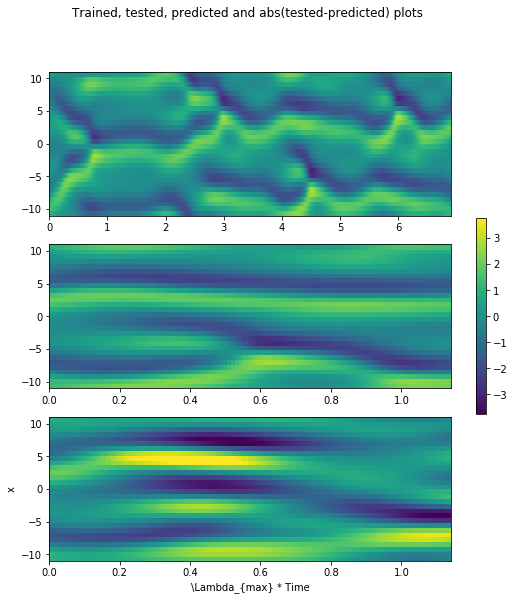

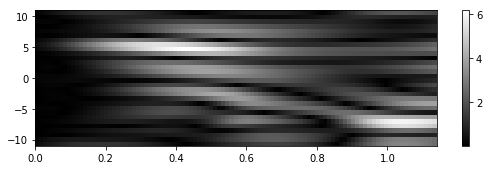

In [33]:
total_pred = b.pred_horizon*b.rec_pred_steps

n_input = 500 #round(pred_output.shape[0]/2-300)

input_data = ks_data[0, :n_input+b.forget, :]

prediction = pred_output[n_input, :].reshape(-1, spatial_points+1)
    
targetted_data = ks_data[0, n_input+b.forget:n_input+b.forget+total_pred, :]

vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    time = (tt[0:n_input+b.forget] if i==0 else tt[0:total_pred])*lyap_exp
    im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(time, xx, datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

<function matplotlib.pyplot.show(*args, **kw)>

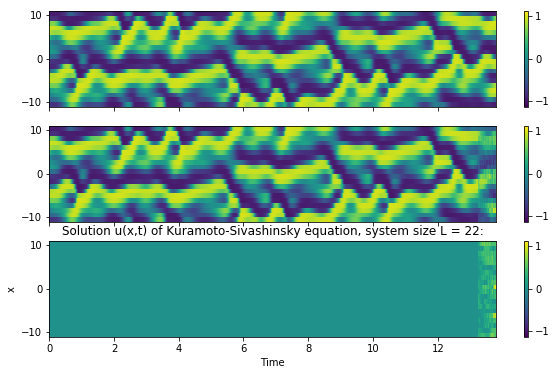

In [14]:
n_input = 1250 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((total_pred, spatial_points + 1))
for i in range(total_pred):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+total_pred, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+total_pred]*lyap_exp
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+total_pred, 0:spatial_points+1].T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[2])
plt.show